In [1]:
import pandas as pd
import numpy as np
import glob, os
from util import *
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import matplotlib.pyplot as plt
from scipy import signal


In [2]:
def re_im_sep(fields):
    shg1 = fields[0:1892] + fields[1892 * 2 + 348:1892 * 3 + 348] * 1j
    shg2 = fields[1892:1892 * 2] + fields[1892 * 3 + 348:1892 * 4 + 348] * 1j
    sfg = fields[1892 * 2:1892 * 2 + 348] + fields[1892 * 4 + 348:1892 * 4 + 2 * 348] * 1j

    return shg1, shg2, sfg
def separate_concat(input_vector,field_durations, factors, phase_factor = np.pi):
    '''
    expecting intensity then phase then energy values for three fields
    '''
    if len(field_durations) != 3:
        print("not enough fields")
    intensity1 = input_vector[0:field_durations[0]]
    intensity2 = input_vector[field_durations[0]:field_durations[0]+field_durations[1]]
    intensity3 = input_vector[field_durations[0]+field_durations[1]:field_durations[0]+field_durations[1]+field_durations[2]]
    phase1 = input_vector[field_durations[0]+field_durations[1]+field_durations[2]:2*field_durations[0]+field_durations[1]+field_durations[2]]
    phase2 = input_vector[2*field_durations[0]+field_durations[1]+field_durations[2]:2*field_durations[0]+2*field_durations[1]+field_durations[2]]
    phase3 = input_vector[2*field_durations[0]+2*field_durations[1]+field_durations[2]:2*field_durations[0]+2*field_durations[1]+2*field_durations[2]]
    energy1 = input_vector[-3]
    energy2 = input_vector[-2]
    energy3 = input_vector[-1]
    

    phase1 = phase1*phase_factor
    phase2 = phase2*phase_factor
    phase3 = phase3*phase_factor

    intensity1 = intensity1/np.max(intensity1)
    field1 = np.sqrt(intensity1)*np.exp(1j*phase1)
    field1 = energy_match_expanded(field1, energy1, factors["domain_spacing_1"], factors["beam_area"] )
    
    #intensity1 = intensity1/np.sum(intensity1)*energy1
    intensity2 = intensity2/np.max(intensity2)
    field2 = np.sqrt(intensity2)*np.exp(1j*phase2)
    field2 = energy_match_expanded(field2, energy2, factors["domain_spacing_2"], factors["beam_area"] )


    #intensity2 = intensity2/np.sum(intensity2)*energy2
    intensity3 = intensity3/np.max(intensity3)
    field3 = np.sqrt(intensity3)*np.exp(1j*phase3)
    field3 = energy_match_expanded(field3, energy3, factors["domain_spacing_3"], factors["beam_area"] )

    #intensity3 = intensity3/np.sum(intensity3)*energy3
    
    return field1, field2, field3, [energy1,energy2,energy3]

def change_domains(domain, field, new_domain, domain_type):
    padded_vector = np.pad(field, (1, 1), mode='constant')
    window = signal.windows.tukey(int(len(padded_vector) // 1))
    padded_vector = window * padded_vector

    # Extend old domain to match new domain
    alt_domain = np.append([new_domain[0]], domain)
    alt_domain = np.append(alt_domain, [new_domain[-1]])

    # Resample padded vector using new domain
    resampled_vector = resample_method1(alt_domain, new_domain, padded_vector)
    

    if (domain_type == "freq"):
        out_direct = ifft(field)
        out = ifft(resampled_vector)
    elif (domain_type == "time"):
        out_direct = fft(field)
        out = fft(resampled_vector)
    else:
        print("field type not supported")

    return out_direct, out


def change_domain_and_adjust_energy(domain, field, new_domain, domain_type, beam_area, domain_spacing,
                                    true_domain_spacing):
    out_direct, out = change_domains(domain, field, new_domain, domain_type)
    domain_spacing_calc = domain[1] - domain[0]
    pulse_energy_calc = calc_energy_expanded(field, domain_spacing_calc, beam_area)
    out_direct = energy_match_expanded(out_direct, pulse_energy_calc, domain_spacing, beam_area)
    out = energy_match_expanded(out, pulse_energy_calc, true_domain_spacing, beam_area)

    print("direct, and resampled energies: ", calc_energy_expanded(out_direct, domain_spacing, beam_area),
          calc_energy_expanded(out, true_domain_spacing, beam_area))

    return out_direct, out


def change_domain_timeFreq(t):
    # Calculate time step and sample frequency
    dt = t[1] - t[0]
    fs = 1 / dt

    # Calculate frequency vector using fftfreq
    n = len(t)
    freqs = np.fft.fftfreq(n, dt)

    # Shift frequency vector so that 0 Hz is in the center
    freqs = np.fft.fftshift(freqs)

    return freqs

def intensity_phase_plot(domains, fields, labels, colors, domain_type, xlims=None, ylabel=None, normalize=False, legend=False,offsets=None,
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False):
    """
    Plot intensity and phase of a field
    """
    if domain_type == "time":
            factor = 1e12
            xlabel = "time (ps)"
    elif domain_type == "wavelength":
        factor = 1e9
        xlabel = "wavelength (nm)"
    elif domain_type == "frequency" or domain_type == "freq":
        factor = 1e-12
        xlabel = "frequency (THz)"
    for ii in range(len(domains)):
        domains[ii] = domains[ii]*factor

    intensities = [get_intensity(field) for field in fields]
    phases = [np.unwrap(get_phase(field)) for field in fields]

    

    ylabel2 = "Phase (rad)"
    #TODO: get clear working so that can call function multiple times and have all plots appear
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6, 4),clear=False)

    axs.set_xlabel(xlabel)

    
    
    for ii in range(len(intensities)):
        if normalize:
            intensity = intensities[ii] / np.max(intensities[ii])
            ylabel1 = "Norm. Intensity (a.u.)"
        else:
            ylabel1 = "Fluence (J/m^2)"
#             warnings.warn("Using default intensity units (J/m^2)")
            intensity = intensities[ii]

        if ylabel is None:
            ylabel1 = ylabel1
        else:
            ylabel1 = ylabel
        if offsets is not None:
            offset = offsets[ii]
        axs.plot(domains[ii], intensity+offset, color=colors[ii], label=labels[ii],alpha=.6)
    if (legend):
        plt.legend()
    if xlims is not None:
        axs.set_xlim(xlims[0], xlims[1])
    axs.set_ylabel(ylabel1, color="black")
    ax2 = axs.twinx()
    for ii in range(len(intensities)):
        
        ax2.plot(domains[ii], phases[ii], color=colors[ii], linestyle="dashed",alpha=.6)

    ax2.set_ylabel(ylabel2, color="black")

    if save:
        if save_name is None:
            raise ValueError("Save name is not specified")
        if "." + save_format not in save_name:
            save_name += "." + save_format
        plt.savefig(save_name, bbox_inches='tight', dpi=300, transparent=True, format=save_format)
    if plot_show:
        plt.show()
    else:
        if ~plot_hold:
            plt.close()

In [3]:
freq_vectors_shg1 = np.load(
    "../Data/shg_freq_domain_ds.npy")
freq_vectors_shg2 = freq_vectors_shg1 # these are equivalent here
freq_vectors_sfg = np.load(
    "../Data/sfg_freq_domain_ds.npy")

domain_spacing_1 = (freq_vectors_shg1[1] - freq_vectors_shg1[0]) * 1e12 #scaled to be back in Hz
domain_spacing_2 = (freq_vectors_shg2[1] - freq_vectors_shg2[0]) * 1e12
domain_spacing_3 = (freq_vectors_sfg[1] - freq_vectors_sfg[0]) * 1e12

factors_freq = {"beam_area": 400e-6 ** 2 * np.pi,
                "grid_spacing": [domain_spacing_1, domain_spacing_2, domain_spacing_3],
                "domain_spacing_1": domain_spacing_1, "domain_spacing_2": domain_spacing_2,
                "domain_spacing_3": domain_spacing_3} #beam radius 400 um (and circular beam)

sfg_original_freq= np.load("../Data/sfg_original_freq_vector.npy")
sfg_original_time= np.load("../Data/sfg_original_time_vector.npy")
sfg_original_time_ds = sfg_original_time[1]-sfg_original_time[0]

Visualization for intensity phase energy (version 1) data
X shape is (10000, 10, 8267)
X example before transformed back


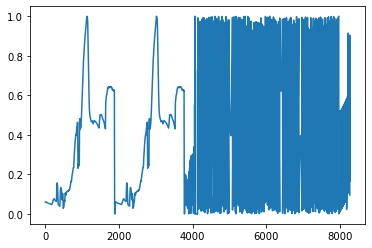

X example after transformed back


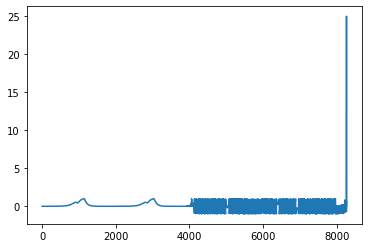

y example before transformed back


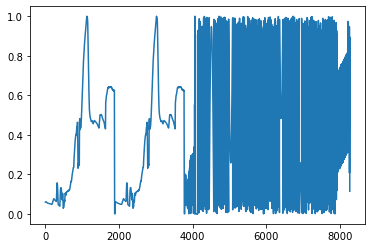

y example after transformed back


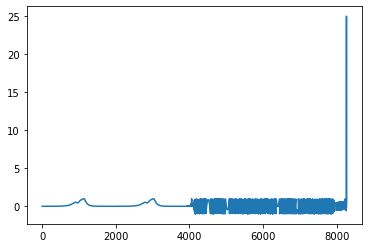

------ Plotting X -------
direct, and resampled energies:  7.21991333678958e-10 7.219913336789581e-10
direct, and resampled energies:  2.499963931022813e-05 2.4999639310228145e-05
direct, and resampled energies:  2.4999639310228135e-05 2.4999639310228138e-05
*** SFG ***


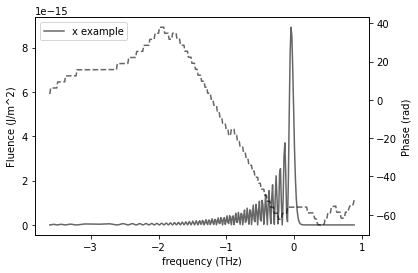

*** SHG1 ***


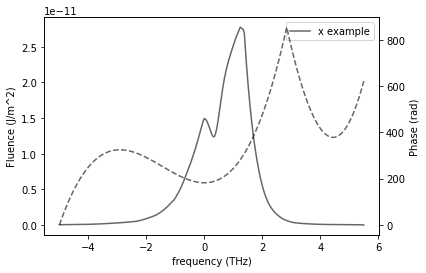

*** SHG2 ***


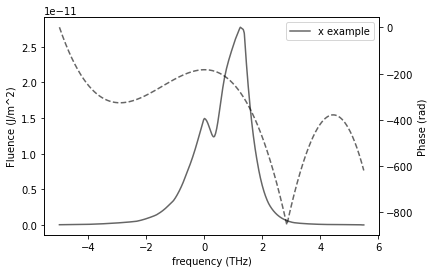

*** SFG ***


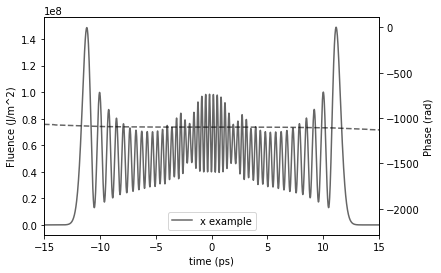

*** SHG1 ***


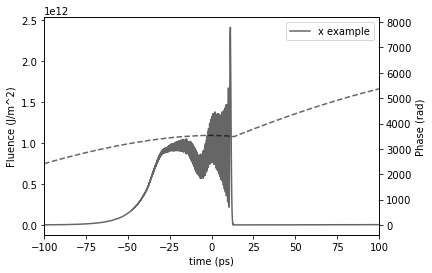

*** SHG2 ***


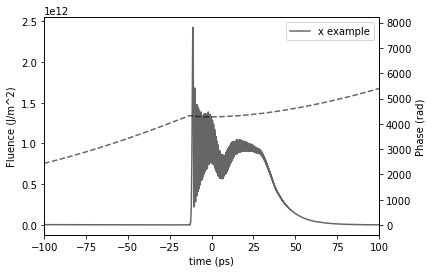

direct, and resampled energies:  8.64634178266757e-10 8.646341782667567e-10
direct, and resampled energies:  2.4999569949206875e-05 2.4999569949206865e-05
direct, and resampled energies:  2.4999567472027545e-05 2.499956747202754e-05
------ Plotting y -------
*** SFG ***


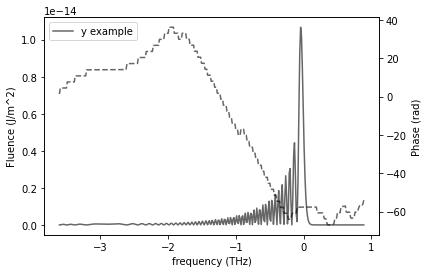

*** SHG1 ***


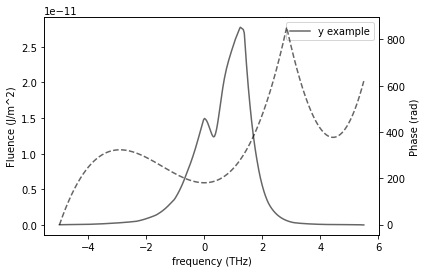

*** SHG2 ***


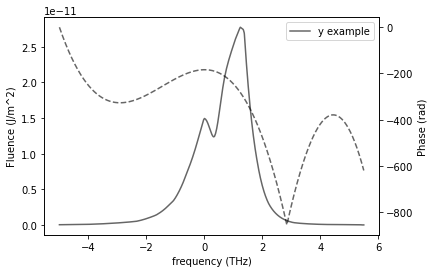

*** SFG ***


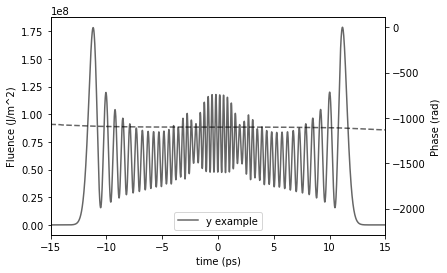

*** SHG1 ***


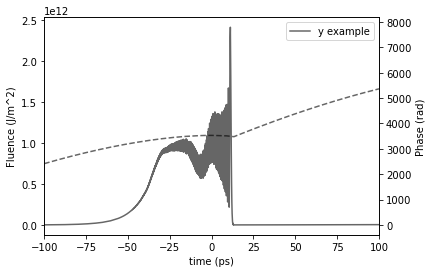

*** SHG2 ***


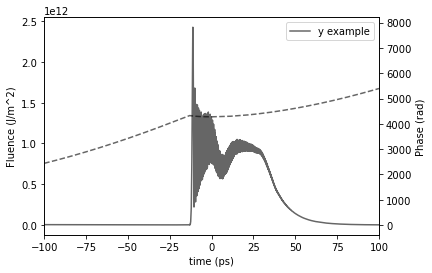

In [6]:
print("Visualization for intensity phase energy (version 1) data")
output_dir = "/sdf/group/lcls/ds/scratch/s2e_scratch/Data/SFG_intPhEn/test" #this is where you just saved data to
X_example = np.load(output_dir+"/X_new_1.npy") #pick an example file
y_example = np.load(output_dir+"/y_new_1.npy")
print("X shape is " + str(X_example.shape))

with open(os.path.join(output_dir, 'scaler_bckkup.pkl'), 'rb') as file: #can use scaler.pkl or scaler_bckkup.pkl
    scaler = pickle.load(file)
X_example_transfered = np.copy(X_example)
y_example_transfered = scaler.inverse_transform(y_example[:,:])
for jj in range(X_example.shape[1]):   
    X_example_transfered[:,jj,:] = scaler.inverse_transform(X_example[:,jj,:])
ii = 67 #the choice of ii and jj matters.. if an example is chosen where the SFG signal is zero (or has zero intensity) then some the plotting that separates the signals out will fail (also remember that can have non-zero phase but zero intensity)
jj = 4
print("X example before transformed back")
plt.plot(X_example[ii,jj,:])
plt.show()
print("X example after transformed back")
X_temp = np.copy(X_example_transfered[ii,jj,:])
X_temp[-3:] = X_temp[-3:]*1e-6 #adjusts some odd scaling choice from before
plt.plot(X_temp)
plt.show()
print("y example before transformed back")
plt.plot(y_example[ii,:])
plt.show()
print("y example after transformed back")
y_temp = np.copy(y_example_transfered[ii,:])
y_temp[-3:] = y_temp[-3:]*1e-6 #adjusts some odd scaling choice from before
plt.plot(y_temp)
plt.show()

#plotting the separated versions of the fields
print("------ Plotting X -------")
x_trans_shg1, x_trans_shg2, x_trans_sfg, x_energies = separate_concat(X_example_transfered[ii,jj,:],field_durations=[1892, 1892, 348], factors=factors_freq)

x_sfg_freq_to_time_direct, x_sfg_freq_to_time=change_domain_and_adjust_energy(freq_vectors_sfg, x_trans_sfg, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_3, true_domain_spacing=sfg_original_time_ds)
x_shg1_freq_to_time_direct, x_shg1_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg1, x_trans_shg1, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_1, true_domain_spacing=sfg_original_time_ds)
x_shg2_freq_to_time_direct, x_shg2_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg2, x_trans_shg2, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_2, true_domain_spacing=sfg_original_time_ds)

print("*** SFG ***")

intensity_phase_plot([freq_vectors_sfg], [x_trans_sfg], ["x example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG1 ***")
intensity_phase_plot([freq_vectors_shg1], [x_trans_shg1], ["x example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG2 ***")
intensity_phase_plot([freq_vectors_shg2], [x_trans_shg2], ["x example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SFG ***")
intensity_phase_plot([sfg_original_time], [x_sfg_freq_to_time], ["x example"], ["black"], "time", xlims=[-15,15], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([sfg_original_time], [x_shg1_freq_to_time], ["x example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([sfg_original_time], [x_shg2_freq_to_time], ["x example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)





y_trans_shg1, y_trans_shg2, y_trans_sfg, y_energies = separate_concat(y_example_transfered[ii,:],field_durations=[1892, 1892, 348], factors=factors_freq)

y_sfg_freq_to_time_direct, y_sfg_freq_to_time=change_domain_and_adjust_energy(freq_vectors_sfg, y_trans_sfg, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_3, true_domain_spacing=sfg_original_time_ds)
y_shg1_freq_to_time_direct, y_shg1_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg1, y_trans_shg1, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_1, true_domain_spacing=sfg_original_time_ds)
y_shg2_freq_to_time_direct, y_shg2_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg2, y_trans_shg2, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_2, true_domain_spacing=sfg_original_time_ds)
print("------ Plotting y -------")

print("*** SFG ***")

intensity_phase_plot([freq_vectors_sfg], [y_trans_sfg], ["y example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG1 ***")
intensity_phase_plot([freq_vectors_shg1], [y_trans_shg1], ["y example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG2 ***")
intensity_phase_plot([freq_vectors_shg2], [y_trans_shg2], ["y example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SFG ***")
intensity_phase_plot([sfg_original_time], [y_sfg_freq_to_time], ["y example"], ["black"], "time", xlims=[-15,15], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([sfg_original_time], [y_shg1_freq_to_time], ["y example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([sfg_original_time], [y_shg2_freq_to_time], ["y example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)





Visualization for real imaginary (version 2) data
X shape is (10000, 10, 8264)
X example before transformed back


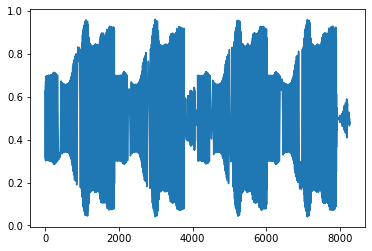

X example after transformed back


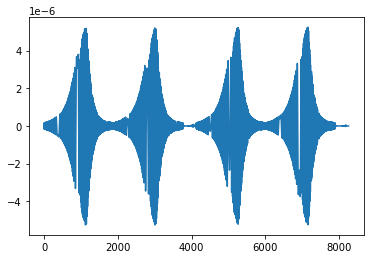

y example before transformed back


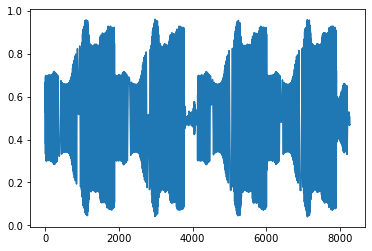

y example after transformed back


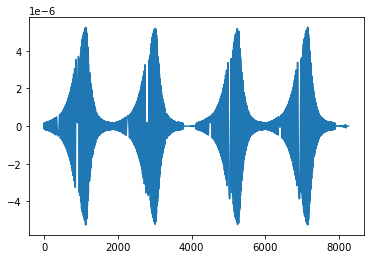

------ Plotting X -------
direct, and resampled energies:  7.219912895804082e-10 7.219912895804077e-10
direct, and resampled energies:  2.4999639310228138e-05 2.499963931022814e-05
direct, and resampled energies:  2.4999639310228135e-05 2.4999639310228145e-05
*** SFG ***


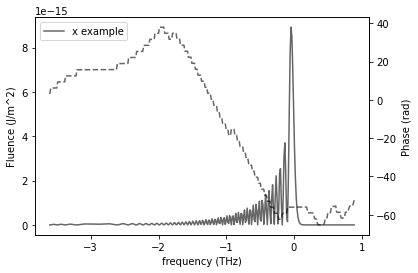

*** SHG1 ***


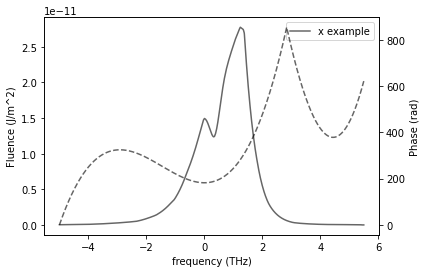

*** SHG2 ***


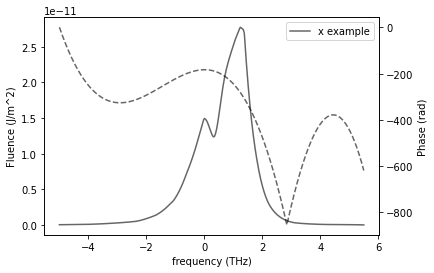

*** SFG ***


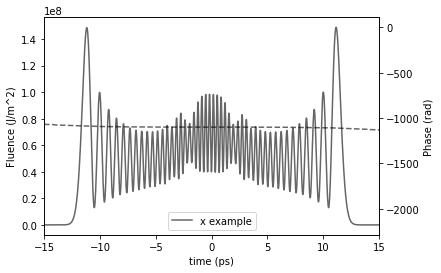

*** SHG1 ***


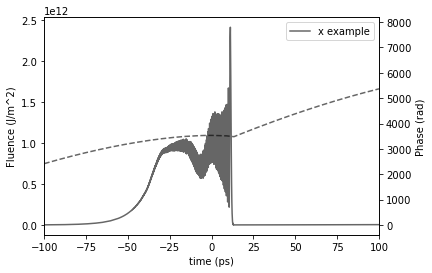

*** SHG2 ***


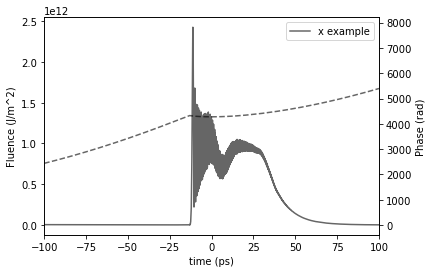

direct, and resampled energies:  8.64634178266757e-10 8.646341782667572e-10
direct, and resampled energies:  2.4999564994848208e-05 2.4999564994848218e-05
direct, and resampled energies:  2.4999567472027538e-05 2.499956747202754e-05
------ Plotting y -------
*** SFG ***


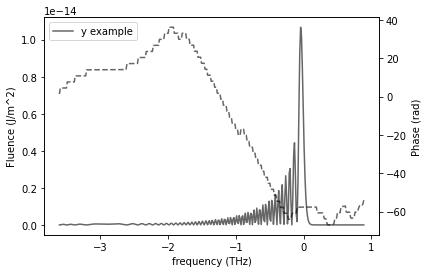

*** SHG1 ***


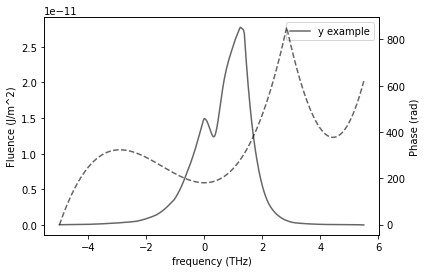

*** SHG2 ***


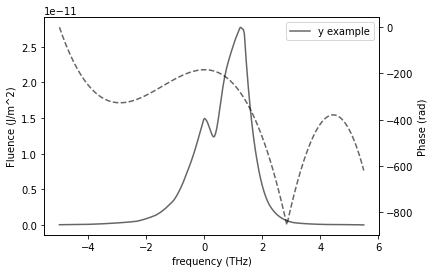

*** SFG ***


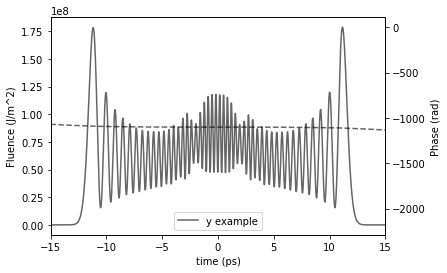

*** SHG1 ***


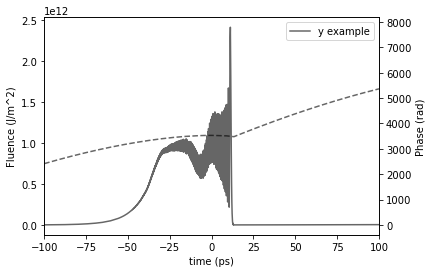

*** SHG2 ***


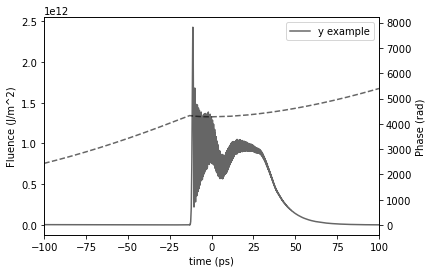

In [5]:
print("Visualization for real imaginary (version 2) data")

output_dir = "/sdf/group/lcls/ds/scratch/s2e_scratch/Data/SFG_reIm/test" #this is where you just saved data to
X_example = np.load(output_dir+"/X_new_1.npy") #pick an example file
y_example = np.load(output_dir+"/y_new_1.npy")
print("X shape is " + str(X_example.shape))

with open(os.path.join(output_dir, 'scaler_bckkup.pkl'), 'rb') as file: #can use scaler.pkl or scaler_bckkup.pkl
    scaler = pickle.load(file)
X_example_transfered = np.copy(X_example)
y_example_transfered = scaler.inverse_transform(y_example[:,:])
for jj in range(X_example.shape[1]):   
    X_example_transfered[:,jj,:] = scaler.inverse_transform(X_example[:,jj,:])
ii = 67 #the choice of ii and jj matters.. if an example is chosen where the SFG signal is zero (or has zero intensity) then some the plotting that separates the signals out will fail (also remember that can have non-zero phase but zero intensity)
jj = 4
print("X example before transformed back")
plt.plot(X_example[ii,jj,:])
plt.show()
print("X example after transformed back")
plt.plot(X_example_transfered[ii,jj,:])
plt.show()
print("y example before transformed back")
plt.plot(y_example[ii,:])
plt.show()
print("y example after transformed back")
plt.plot(y_example_transfered[ii,:])
plt.show()

#plotting the separated versions of the fields
print("------ Plotting X -------")
x_trans_shg1, x_trans_shg2, x_trans_sfg = re_im_sep(X_example_transfered[ii,jj,:])

x_sfg_freq_to_time_direct, x_sfg_freq_to_time=change_domain_and_adjust_energy(freq_vectors_sfg, x_trans_sfg, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_3, true_domain_spacing=sfg_original_time_ds)
x_shg1_freq_to_time_direct, x_shg1_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg1, x_trans_shg1, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_1, true_domain_spacing=sfg_original_time_ds)
x_shg2_freq_to_time_direct, x_shg2_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg2, x_trans_shg2, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_2, true_domain_spacing=sfg_original_time_ds)

print("*** SFG ***")

intensity_phase_plot([freq_vectors_sfg], [x_trans_sfg], ["x example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG1 ***")
intensity_phase_plot([freq_vectors_shg1], [x_trans_shg1], ["x example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG2 ***")
intensity_phase_plot([freq_vectors_shg2], [x_trans_shg2], ["x example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SFG ***")
intensity_phase_plot([sfg_original_time], [x_sfg_freq_to_time], ["x example"], ["black"], "time", xlims=[-15,15], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([sfg_original_time], [x_shg1_freq_to_time], ["x example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([sfg_original_time], [x_shg2_freq_to_time], ["x example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)





y_trans_shg1, y_trans_shg2, y_trans_sfg = re_im_sep(y_example_transfered[ii,:])

y_sfg_freq_to_time_direct, y_sfg_freq_to_time=change_domain_and_adjust_energy(freq_vectors_sfg, y_trans_sfg, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_3, true_domain_spacing=sfg_original_time_ds)
y_shg1_freq_to_time_direct, y_shg1_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg1, y_trans_shg1, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_1, true_domain_spacing=sfg_original_time_ds)
y_shg2_freq_to_time_direct, y_shg2_freq_to_time=change_domain_and_adjust_energy(freq_vectors_shg2, y_trans_shg2, sfg_original_freq, "freq", beam_area=factors_freq["beam_area"],domain_spacing=domain_spacing_2, true_domain_spacing=sfg_original_time_ds)
print("------ Plotting y -------")

print("*** SFG ***")

intensity_phase_plot([freq_vectors_sfg], [y_trans_sfg], ["y example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG1 ***")
intensity_phase_plot([freq_vectors_shg1], [y_trans_shg1], ["y example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SHG2 ***")
intensity_phase_plot([freq_vectors_shg2], [y_trans_shg2], ["y example"], ["black"], "freq", normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)

print("*** SFG ***")
intensity_phase_plot([sfg_original_time], [y_sfg_freq_to_time], ["y example"], ["black"], "time", xlims=[-15,15], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG1 ***")
intensity_phase_plot([sfg_original_time], [y_shg1_freq_to_time], ["y example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)
print("*** SHG2 ***")
intensity_phase_plot([sfg_original_time], [y_shg2_freq_to_time], ["y example"], ["black"], "time", xlims=[-100,100], normalize=False, legend=True,offsets=[0],
                                save_format="pdf", save_name=None, save=False, plot_show=True,plot_hold=False)



